In [1]:
import os
import sys
import logging
import argparse
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset


In [2]:
path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project'
data_path = path + '/data/'
data = pd.read_csv(data_path + '수정주가(원).csv')
data.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index)
data.index.get_loc('2012-01-02')
data_inf = data.iloc[data.index.get_loc('2012-01-02'):, :]
# 삼성전자와 sk하이닉스만 사용
data_inf = data_inf.loc[:, ['A005930', 'A000660']]
econmic_index = pd.read_csv(data_path + '경기종합지수_2020100__10차__20231208161859.csv')
econmic_index = pd.DataFrame(econmic_index.iloc[1,]).T
econmic_index.index = econmic_index.iloc[:, 0]
econmic_index = econmic_index.iloc[:, 1:]
econmic_index = econmic_index.astype(float)
# 전달 대비 상위 75%는 상승
# 전달 대비 하위 25%는 하락
# 25% ~ 75%는 변동 없음
econmic_index.T.describe()
econmic_index = econmic_index.iloc[:, 189:]
col_list = econmic_index.columns
threshold_75 = np.percentile(econmic_index, 75)
threshold_25 = np.percentile(econmic_index, 25)
econmic_index = np.where(econmic_index >= threshold_75, 1, np.where(econmic_index >= threshold_25, 0, -1))
econmic_index = pd.DataFrame(econmic_index)
econmic_index.columns = col_list
econmic_index = econmic_index.T
econmic_index.rename(columns={0: 'econmic_index'}, inplace=True)
data_inf['str_index'] = data_inf.index.strftime('%Y.%m')
data_tot = data_inf.merge(econmic_index, left_on='str_index', right_index=True)
data_tot.drop('str_index', axis=1, inplace=True)
data_tot['A005930'].replace(',', '', regex=True, inplace=True)
data_tot['A000660'].replace(',', '', regex=True, inplace=True)
data_tot['A005930'] = data_tot['A005930'].astype(float)
data_tot['A000660'] = data_tot['A000660'].astype(float)
samsung = data_tot[['A005930', 'econmic_index']]
hinix = data_tot[['A000660', 'econmic_index']]
samsung.rename(columns={'A005930': 'Close'}, inplace=True)
hinix.rename(columns={'A000660': 'Close'}, inplace=True)
# EMA (Exponential Moving Average) 계산
def calculate_ema(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

# MACD (Moving Average Convergence Divergence) 계산
def calculate_macd(data, short_window, long_window):
    short_ema = calculate_ema(data, short_window)
    long_ema = calculate_ema(data, long_window)

    macd = short_ema - long_ema

    return macd

# Log Return 계산
def calculate_log_return(data):
    return np.log(data['Close'] / data['Close'].shift(1))
# EMA, MACD, Log Return 계산
samsung['EMA_5'] = calculate_ema(samsung, 5)
samsung['EMA_20'] = calculate_ema(samsung, 20)
samsung['MACD'] = calculate_macd(samsung, 5, 20)
samsung['Log_Return'] = calculate_log_return(samsung)
# EMA, MACD, Log Return 계산
hinix['EMA_5'] = calculate_ema(hinix, 5)
hinix['EMA_20'] = calculate_ema(hinix, 20)
hinix['MACD'] = calculate_macd(hinix, 5, 20)
hinix['Log_Return'] = calculate_log_return(hinix)
hinix = hinix.iloc[1:,]
samsung = samsung.iloc[1:,]
samsung_train = samsung.iloc[:samsung.index.get_loc('2017-12-28')+1, :]
samsung_test = samsung.iloc[samsung.index.get_loc('2017-12-28')+1:, :]
hinix_train = hinix.iloc[:hinix.index.get_loc('2017-12-28')+1, :]
hinix_test = hinix.iloc[hinix.index.get_loc('2017-12-28')+1:, :]

/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_60858/3606678312.py:3: DtypeWarning: Columns (2,4,6,8,11,13,14,15,17,18,19,20,21,22,23,28,31,32,36,38,42,43,44,47,48,49,51,52,53,54,55,56,59,61,62,63,64,65,66,70,73,74,75,77,83,84,85,86,87,88,92,93,98,100,101,102,103,104,105,106,107,110,112,113,114,116,118,119,122,124,125,127,131,132,133,137,138,141,143,144,145,146,149,151,152,155,156,157,159,163,165,166,168,169,170,174,175,176,177,178,180,181,182,183,185,186,188,189,190,194,196,197,198,200,201,202,203,204,205,206,207,212,213,215,216,219,220,221,222,223,224,225,226,227,228,229,232,237,239,240,241,242,243,244,245,246,247,248,250,251,252,254,255,256,257,259,262,263,264,265,266,268,269,270,271,272,273,274,278,279,280,282,283,284,286,288,289,290,291,292,293,294,295,296,297,298,299,300,304,305,306,307,308,309,312,313,314,316,317,318,320,322,323,324,325,326,327,328,329,333,334,335,336,338,339,340,341,342,343,345,348,350,351,353,354,356,357,358,359,360,361,363,364,365,366,367,369,370,

In [7]:
path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project'
data_path = path + '/data/'
data = pd.read_csv(data_path + '수정주가(원).csv')
data.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index)
data.index.get_loc('2012-01-02')
data_inf = data.iloc[data.index.get_loc('2012-01-02'):, :]
# 삼성전자와 sk하이닉스만 사용
data_inf = data_inf.loc[:, ['A005930', 'A000660']]
data_inf['str_index'] = data_inf.index.strftime('%Y.%m')
data_inf = data_inf.merge(econmic_index, left_on='str_index', right_index=True)
data_inf.drop('str_index', axis=1, inplace=True)
data_inf['A005930'].replace(',', '', regex=True, inplace=True)
data_inf['A000660'].replace(',', '', regex=True, inplace=True)
data_inf['A005930'] = data_inf['A005930'].astype(float)
data_inf['A000660'] = data_inf['A000660'].astype(float)
samsung = data_inf[['A005930']]
hinix = data_inf[['A000660']]
samsung.rename(columns={'A005930': 'Close'}, inplace=True)
hinix.rename(columns={'A000660': 'Close'}, inplace=True)
# EMA (Exponential Moving Average) 계산
def calculate_ema(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

# MACD (Moving Average Convergence Divergence) 계산
def calculate_macd(data, short_window, long_window):
    short_ema = calculate_ema(data, short_window)
    long_ema = calculate_ema(data, long_window)

    macd = short_ema - long_ema

    return macd

# Log Return 계산
def calculate_log_return(data):
    return np.log(data['Close'] / data['Close'].shift(1))
# EMA, MACD, Log Return 계산
samsung['EMA_5'] = calculate_ema(samsung, 5)
samsung['EMA_20'] = calculate_ema(samsung, 20)
samsung['MACD'] = calculate_macd(samsung, 5, 20)
samsung['Log_Return'] = calculate_log_return(samsung)
# EMA, MACD, Log Return 계산
hinix['EMA_5'] = calculate_ema(hinix, 5)
hinix['EMA_20'] = calculate_ema(hinix, 20)
hinix['MACD'] = calculate_macd(hinix, 5, 20)
hinix['Log_Return'] = calculate_log_return(hinix)
hinix = hinix.iloc[1:,]
samsung = samsung.iloc[1:,]
non_samsung_train = samsung.iloc[:samsung.index.get_loc('2017-12-28')+1, :]
non_samsung_test = samsung.iloc[samsung.index.get_loc('2017-12-28')+1:, :]
non_hinix_train = hinix.iloc[:hinix.index.get_loc('2017-12-28')+1, :]
non_hinix_test = hinix.iloc[hinix.index.get_loc('2017-12-28')+1:, :]

/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_60858/3975369212.py:3: DtypeWarning: Columns (2,4,6,8,11,13,14,15,17,18,19,20,21,22,23,28,31,32,36,38,42,43,44,47,48,49,51,52,53,54,55,56,59,61,62,63,64,65,66,70,73,74,75,77,83,84,85,86,87,88,92,93,98,100,101,102,103,104,105,106,107,110,112,113,114,116,118,119,122,124,125,127,131,132,133,137,138,141,143,144,145,146,149,151,152,155,156,157,159,163,165,166,168,169,170,174,175,176,177,178,180,181,182,183,185,186,188,189,190,194,196,197,198,200,201,202,203,204,205,206,207,212,213,215,216,219,220,221,222,223,224,225,226,227,228,229,232,237,239,240,241,242,243,244,245,246,247,248,250,251,252,254,255,256,257,259,262,263,264,265,266,268,269,270,271,272,273,274,278,279,280,282,283,284,286,288,289,290,291,292,293,294,295,296,297,298,299,300,304,305,306,307,308,309,312,313,314,316,317,318,320,322,323,324,325,326,327,328,329,333,334,335,336,338,339,340,341,342,343,345,348,350,351,353,354,356,357,358,359,360,361,363,364,365,366,367,369,370,

In [8]:
model_path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/models/'

In [9]:
samsung_non_model_name = 'non_samsung_model_dqn_dnn_value.mdl'
samsung_model_name = 'samsung_model_dqn_dnn_value.mdl'
hinx_non_model_name = 'non_hinix_model_dqn_dnn_value.mdl'
hinx_model_name = 'hinx_model_dqn_dnn_value.mdl'

In [10]:
model = torch.load(model_path+hinx_model_name)

In [11]:
model

Sequential(
  (0): Sequential(
    (0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=9, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [12]:
# mode : 실행모드
# ['train', 'test', 'update', 'predict']
mode = 'predict'
name = "hinix_model"
rl_method = 'dqn'
net = 'dnn'
backend = 'pytorch'
lr = 0.001
discount_factor = 0.7
balance = 50000000
output_name = f'{mode}_{name}_{rl_method}_{net}'
learning = mode in ['train', 'update']
reuse_models = mode in ['test', 'update', 'predict']
value_network_name = f'{name}_{rl_method}_{net}_value.mdl'
policy_network_name = f'{name}_{rl_method}_{net}_policy.mdl'
start_epsilon = 1 if mode in ['train', 'update'] else 0
num_epoches = 100 if mode in ['train', 'update'] else 1
num_steps = 5 if net in ['lstm', 'cnn'] else 1
os.environ['RLTRADER_BACKEND'] = backend
base_path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/'
output_path = os.path.join('/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/', output_name)
if not os.path.isdir(output_path):
    os.makedirs(output_path)


# 모델 경로 준비
# 모델 포멧은 TensorFlow는 h5, PyTorch는 pickle
value_network_path = os.path.join(base_path, 'models', value_network_name)
policy_network_path = os.path.join(base_path, 'models', policy_network_name)
LOGGER_NAME = 'rltrader'
# 로그 기록 설정
log_path = os.path.join(output_path, f'{output_name}.log')
if os.path.exists(log_path):
    os.remove(log_path)
logging.basicConfig(format='%(message)s')
logger = logging.getLogger(LOGGER_NAME)
logger.setLevel(logging.DEBUG)
logger.propagate = False
stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setLevel(logging.INFO)
file_handler = logging.FileHandler(filename=log_path, encoding='utf-8')
file_handler.setLevel(logging.DEBUG)
logger.addHandler(stream_handler)
logger.addHandler(file_handler)

# Backend 설정, 로그 설정을 먼저하고 RLTrader 모듈들을 이후에 임포트해야 함
from learner import DQNLearner

common_params = {}
list_stock_code = []
list_chart_data = []
list_training_data = []
list_min_trading_price = []
list_max_trading_price = []
assert len(samsung_test) >= num_steps
# 최소/최대 단일 매매 금액 설정
min_trading_price = 100000
max_trading_price = 10000000

Enabling PyTorch...


In [13]:

# 공통 파라미터 설정
common_params = {'rl_method': rl_method,
    'net': net, 'num_steps': num_steps, 'lr': lr,
    'balance': balance, 'num_epoches': num_epoches,
    'discount_factor': discount_factor, 'start_epsilon': start_epsilon,
    'output_path': output_path, 'reuse_models': reuse_models}

samsung_train['date'] = samsung_train.index
samsung_train.reset_index(drop=True, inplace=True)
samsung_test['date'] = samsung_test.index
samsung_test.reset_index(drop=True, inplace=True)
hinix_train['date'] = hinix_train.index
hinix_train.reset_index(drop=True, inplace=True)
hinix_test['date'] = hinix_test.index
hinix_test.reset_index(drop=True, inplace=True)

# print(samsung_test.shape, samsung_train.shape)
# 강화학습 시작
common_params.update({
    'chart_data': hinix_test,
    'training_data': hinix_test,
    'min_trading_price': min_trading_price,
    'max_trading_price': max_trading_price})

In [14]:

learner = DQNLearner(**{**common_params, 'value_network_path': value_network_path})
if mode in ['train', 'test', 'update']:
    learner.run(learning=learning)
    if mode in ['train', 'update']:
        learner.save_models()
elif mode == 'predict':
    learner.predict()

/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/enviroment.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.observation[self.PRICE_IDX]
/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/learner.py:336: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result.append((self.environment.observation[0], pred_value, pred_policy))


In [15]:
# 정규 표현식을 사용하여 각 필드를 추출하는 함수
def parse_epoch_info(epoch_str):
    pattern = r'\[Epoch (\d+)/\d+\] Epsilon:([\d.]+) #Expl.:(\d+)/(\d+) #Buy:(\d+) #Sell:(\d+) #Hold:(\d+) #Stocks:(\d+) PV:([\d,]+) Loss:([\d.]+) ET:([\d.]+)'
    match = re.match(pattern, epoch_str)
    
    if match:
        return {
            'Epoch': int(match.group(1)),
            'Epsilon': float(match.group(2)),
            'Exploration': int(match.group(3)),
            'Total Exploration': int(match.group(4)),
            'Buy': int(match.group(5)),
            'Sell': int(match.group(6)),
            'Hold': int(match.group(7)),
            'Stocks': int(match.group(8)),
            'PV': int(match.group(9).replace(',', '')),
            'Loss': float(match.group(10)),
            'Elapsed Time': float(match.group(11))
        }
    else:
        return None


In [16]:
samsung_file_path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/train_samsung_model_dqn_dnn/train_samsung_model_dqn_dnn.log'

# 파일 열기
with open(samsung_file_path, 'r') as file:
    # 파일 내용 읽기
    samsung_contents = file.read()



In [17]:
non_samsung_file_path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/train_non_samsung_model_dqn_dnn/train_non_samsung_model_dqn_dnn.log'

# 파일 열기
with open(non_samsung_file_path, 'r') as file:
    # 파일 내용 읽기
    non_samsung_contents = file.read()


In [18]:
non_hynix_file_path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/train_non_hinix_model_dqn_dnn/train_non_hinix_model_dqn_dnn.log'

# 파일 열기
with open(non_hynix_file_path, 'r') as file:
    # 파일 내용 읽기
    non_hynix_contents = file.read()


In [19]:
hynix_file_path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/train_hinx_model_dqn_dnn/train_hinx_model_dqn_dnn.log'

# 파일 열기
with open(hynix_file_path, 'r') as file:
    # 파일 내용 읽기
    hynix_file_contents = file.read()


In [20]:
import re
# 각 에포크 정보를 추출하여 리스트에 저장
epoch_list = []
epoch_str_list = samsung_contents.split('\n')
for epoch_str in epoch_str_list:
    if '[Epoch' in epoch_str:
        epoch_info = parse_epoch_info(epoch_str)
        if epoch_info:
            epoch_list.append(epoch_info)

# DataFrame으로 변환
samsung = pd.DataFrame(epoch_list)

# Elapsed Time과 Max PV를 추출
elapsed_time_match = re.search(r'Elapsed Time:([\d.]+)', samsung_contents)
max_pv_match = re.search(r'Max PV:([\d,]+)', samsung_contents)

elapsed_time = float(elapsed_time_match.group(1)) if elapsed_time_match else None
max_pv = int(max_pv_match.group(1).replace(',', '')) if max_pv_match else None

# 결과 출력
print("Epoch 정보:")
print(samsung)
print("\nElapsed Time:", elapsed_time)
print("Max PV:", max_pv)

Epoch 정보:
    Epoch  Epsilon  Exploration  Total Exploration  Buy  Sell  Hold  Stocks  \
0       1   1.0000         1476               1476  399   419   658       0   
1       2   0.9899         1467               1476  457   403   616     828   
2       3   0.9798         1443               1476  456   412   608     458   
3       4   0.9697         1429               1476  477   446   553     348   
4       5   0.9596         1414               1476  499   469   508       0   
..    ...      ...          ...                ...  ...   ...   ...     ...   
95     96   0.0404           57               1476   17    19  1440       0   
96     97   0.0303           41               1476   16    18  1442       0   
97     98   0.0202           29               1476    9    11  1456       0   
98     99   0.0101           16               1476    8    10  1458       0   
99    100   0.0000            0               1476    0     0  1476       0   

          PV         Loss  Elapsed Time  

In [21]:
import re
# 각 에포크 정보를 추출하여 리스트에 저장
epoch_list = []
epoch_str_list = non_samsung_contents.split('\n')
for epoch_str in epoch_str_list:
    if '[Epoch' in epoch_str:
        epoch_info = parse_epoch_info(epoch_str)
        if epoch_info:
            epoch_list.append(epoch_info)

# DataFrame으로 변환
non_samsung = pd.DataFrame(epoch_list)

# Elapsed Time과 Max PV를 추출
elapsed_time_match = re.search(r'Elapsed Time:([\d.]+)', non_samsung_contents)
max_pv_match = re.search(r'Max PV:([\d,]+)', non_samsung_contents)

elapsed_time = float(elapsed_time_match.group(1)) if elapsed_time_match else None
max_pv = int(max_pv_match.group(1).replace(',', '')) if max_pv_match else None

# 결과 출력
print("Epoch 정보:")
print(non_samsung)
print("\nElapsed Time:", elapsed_time)
print("Max PV:", max_pv)

Epoch 정보:
    Epoch  Epsilon  Exploration  Total Exploration  Buy  Sell  Hold  Stocks  \
0       1   1.0000         1476               1476  401   419   656       0   
1       2   0.9899         1451               1476  489   446   541    1113   
2       3   0.9798         1448               1476  489   430   557    1087   
3       4   0.9697         1423               1476  461   441   574     108   
4       5   0.9596         1416               1476  465   444   567     296   
..    ...      ...          ...                ...  ...   ...   ...     ...   
95     96   0.0404           57               1476   35    30  1411    2026   
96     97   0.0303           48               1476   29    29  1418    1570   
97     98   0.0202           34               1476   33    25  1418    1951   
98     99   0.0101           11               1476   18    16  1442    1860   
99    100   0.0000            0               1476   18    15  1443    1891   

           PV         Loss  Elapsed Time 

In [22]:
non_hynix_contents

'[RL:dqn NET:dnn LR:0.001 DF:0.7 \n[Epoch 001/100] Epsilon:1.0000 #Expl.:1476/1476 #Buy:518 #Sell:499 #Hold:459 #Stocks:77 PV:54,526,108 Loss:9641.829102 ET:0.2973\n[Epoch 002/100] Epsilon:0.9899 #Expl.:1463/1476 #Buy:491 #Sell:405 #Hold:580 #Stocks:0 PV:60,488,282 Loss:1.780877 ET:0.2176\n[Epoch 003/100] Epsilon:0.9798 #Expl.:1451/1476 #Buy:449 #Sell:401 #Hold:626 #Stocks:0 PV:53,659,561 Loss:0.974900 ET:0.2085\n[Epoch 004/100] Epsilon:0.9697 #Expl.:1433/1476 #Buy:467 #Sell:427 #Hold:582 #Stocks:0 PV:48,096,667 Loss:0.570909 ET:0.2083\n[Epoch 005/100] Epsilon:0.9596 #Expl.:1423/1476 #Buy:467 #Sell:431 #Hold:578 #Stocks:44 PV:66,715,692 Loss:0.434080 ET:0.2091\n[Epoch 006/100] Epsilon:0.9495 #Expl.:1409/1476 #Buy:447 #Sell:419 #Hold:610 #Stocks:141 PV:79,488,481 Loss:0.365841 ET:0.2676\n[Epoch 007/100] Epsilon:0.9394 #Expl.:1400/1476 #Buy:471 #Sell:442 #Hold:563 #Stocks:405 PV:68,514,274 Loss:0.229597 ET:0.2122\n[Epoch 008/100] Epsilon:0.9293 #Expl.:1372/1476 #Buy:461 #Sell:449 #Hold:5

In [23]:
# 정규 표현식을 사용하여 각 항목을 추출
pattern = re.compile(r'\[Epoch (\d+)/\d+\] Epsilon:([\d.]+) #Expl.:(\d+)/(\d+) #Buy:(\d+) #Sell:(\d+) #Hold:(\d+) #Stocks:(\d+) PV:([\d,]+) Loss:([\d.]+) ET:([\d.]+)')

matches = pattern.findall(non_hynix_contents)

# 추출된 데이터를 데이터프레임으로 변환
columns = ['Epoch', 'Epsilon', 'Exploration', 'TotalExploration', 'Buy', 'Sell', 'Hold', 'Stocks', 'PV', 'Loss', 'Elapsed Time']
non_hynix = pd.DataFrame(matches, columns=columns)

# PV 열의 쉼표 제거 및 숫자로 변환
non_hynix['PV'] = non_hynix['PV'].str.replace(',', '').astype(int)

# 소수점으로 된 열들의 데이터 타입 변환
float_columns = ['Epsilon', 'Loss', 'Elapsed Time']
non_hynix[float_columns] = non_hynix[float_columns].astype(float)

# 결과 출력
print(non_hynix)

   Epoch  Epsilon Exploration TotalExploration  Buy Sell  Hold Stocks  \
0    001   1.0000        1476             1476  518  499   459     77   
1    002   0.9899        1463             1476  491  405   580      0   
2    003   0.9798        1451             1476  449  401   626      0   
3    004   0.9697        1433             1476  467  427   582      0   
4    005   0.9596        1423             1476  467  431   578     44   
..   ...      ...         ...              ...  ...  ...   ...    ...   
95   096   0.0404          52             1476   22   20  1434    620   
96   097   0.0303          48             1476   22   18  1436    506   
97   098   0.0202          19             1476   15    8  1453    501   
98   099   0.0101          14             1476   17    7  1452   1182   
99   100   0.0000           0             1476   10    3  1463    483   

          PV         Loss  Elapsed Time  
0   54526108  9641.829102        0.2973  
1   60488282     1.780877        0.2176

In [24]:
# 정규 표현식을 사용하여 각 항목을 추출
pattern = re.compile(r'\[Epoch (\d+)/\d+\] Epsilon:([\d.]+) #Expl.:(\d+)/(\d+) #Buy:(\d+) #Sell:(\d+) #Hold:(\d+) #Stocks:(\d+) PV:([\d,]+) Loss:([\d.]+) ET:([\d.]+)')

matches = pattern.findall(hynix_file_contents)

# 추출된 데이터를 데이터프레임으로 변환
columns = ['Epoch', 'Epsilon', 'Exploration', 'TotalExploration', 'Buy', 'Sell', 'Hold', 'Stocks', 'PV', 'Loss', 'Elapsed Time']
hyninx = pd.DataFrame(matches, columns=columns)

# PV 열의 쉼표 제거 및 숫자로 변환
hyninx['PV'] = hyninx['PV'].str.replace(',', '').astype(int)

# 소수점으로 된 열들의 데이터 타입 변환
float_columns = ['Epsilon', 'Loss', 'Elapsed Time']
hyninx[float_columns] = hyninx[float_columns].astype(float)

# 결과 출력
print(hyninx)

   Epoch  Epsilon Exploration TotalExploration  Buy Sell  Hold Stocks  \
0    001      0.0           0             1476    6    0  1470   2087   
1    002      0.0           0             1476    9    0  1467   2074   
2    003      0.0           0             1476  144  151  1181      0   
3    004      0.0           0             1476  139  146  1191      0   
4    005      0.0           0             1476  149  161  1166      0   
..   ...      ...         ...              ...  ...  ...   ...    ...   
95   096      0.0           0             1476    6    0  1470   2086   
96   097      0.0           0             1476    6    0  1470   2086   
97   098      0.0           0             1476    7    0  1469   2087   
98   099      0.0           0             1476    8    1  1467   2090   
99   100      0.0           0             1476    8    2  1466   2094   

           PV          Loss  Elapsed Time  
0   159669103  11020.590820        0.4354  
1   158674803      4.464684        

In [25]:
hinix_test.shape

(1223, 7)

## 삼성전자 시각화

In [26]:
initial_investment = 50000000
samsung['Log_Return'] = np.log(samsung['PV'] / initial_investment)
non_samsung['Log_Return'] = np.log(non_samsung['PV'] / initial_investment)
samsung_train['Log_Return'] = np.log(samsung_train['Close'] / samsung_train['Close'].shift(1))
samsung_train['Cumulative_Log_Return'] = samsung_train['Log_Return'].cumsum()




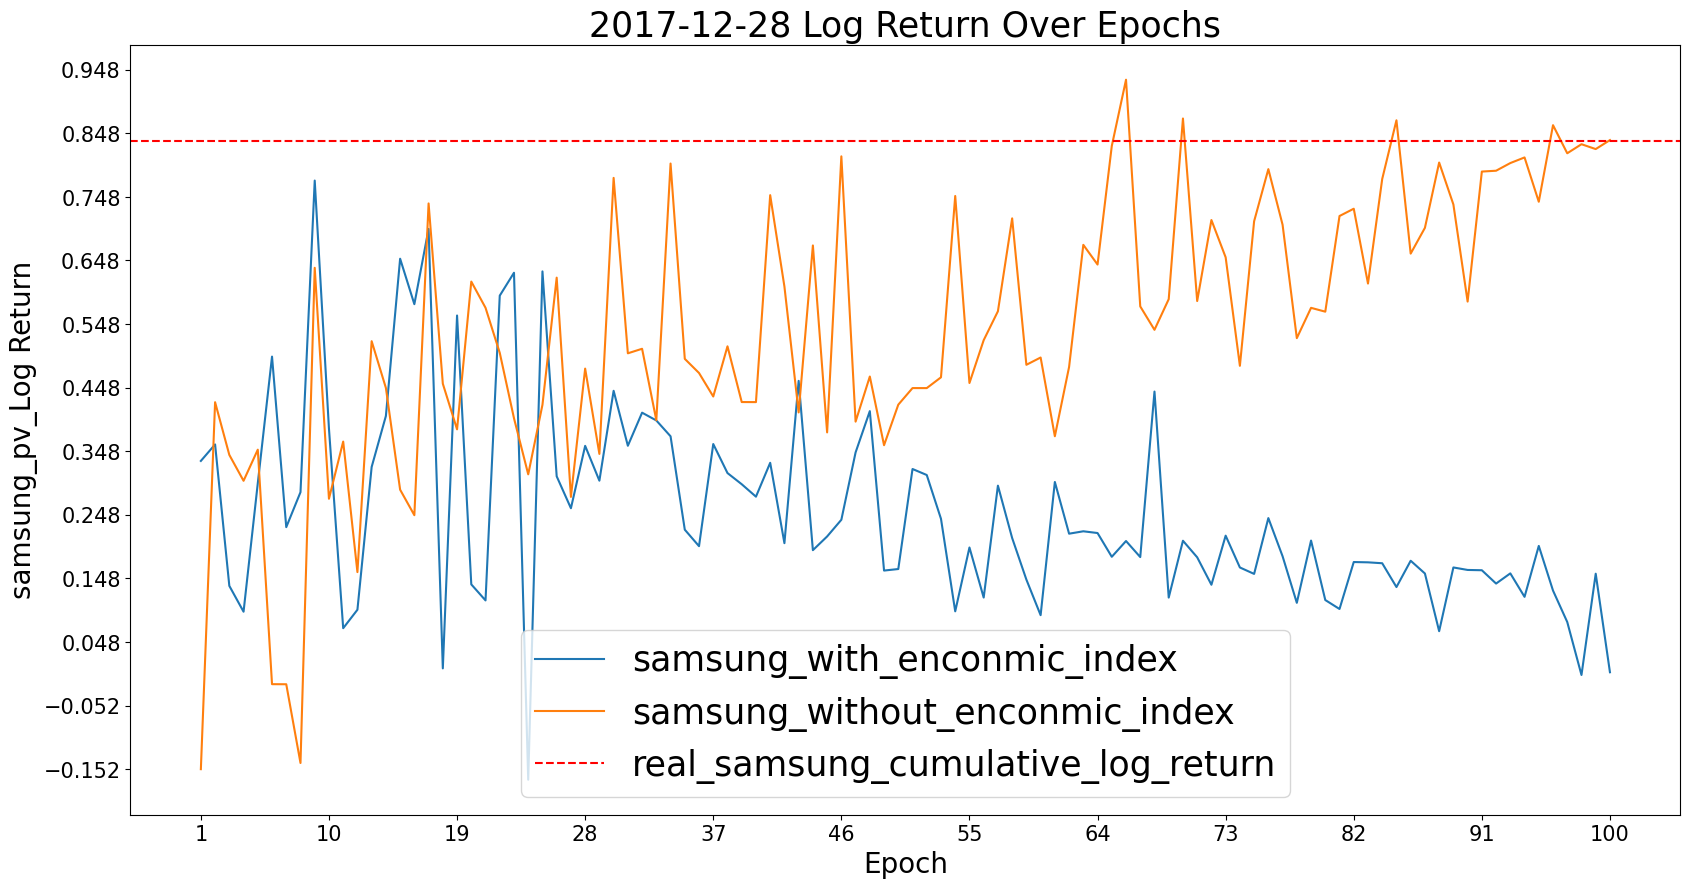

In [27]:
# 그래프 그리기
plt.figure(figsize=(20, 10))
plt.plot(samsung['Epoch'], samsung['Log_Return'], label='samsung_with_enconmic_index')
plt.plot(non_samsung['Epoch'], non_samsung['Log_Return'], label='samsung_without_enconmic_index')
plt.axhline(y=samsung_train['Cumulative_Log_Return'].iloc[-1], color='r', linestyle='--', label='real_samsung_cumulative_log_return')

# 그래프 제목과 레이블 추가
plt.title('2017-12-28 Log Return Over Epochs', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('samsung_pv_Log Return', fontsize=20)
plt.legend(fontsize=25)
plt.xticks(np.arange(min(samsung['Epoch']), max(samsung['Epoch'])+1, 9), fontsize=15)
plt.yticks(np.arange(min(non_samsung['Log_Return']), max(non_samsung['Log_Return'])+0.1, 0.1), fontsize=15)
# 그래프 표시
plt.show()

Text(0.5, 1.0, '2017-12-28 compare Sell Over Epochs')

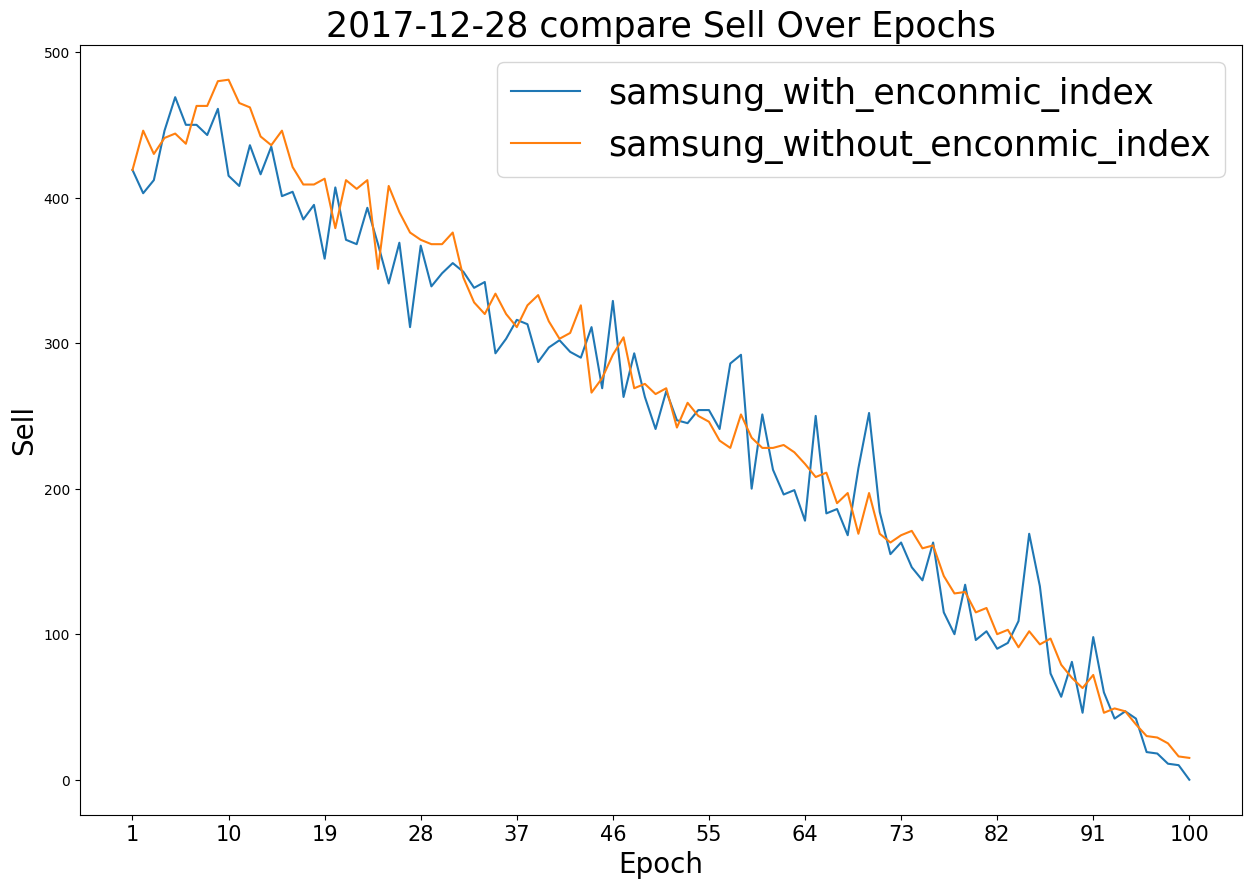

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(samsung['Epoch'], samsung['Sell'], label='samsung_with_enconmic_index')
plt.plot(non_samsung['Epoch'], non_samsung['Sell'], label='samsung_without_enconmic_index')
plt.xticks(np.arange(min(samsung['Epoch']), max(samsung['Epoch'])+1, 9), fontsize=15)
plt.legend(fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Sell', fontsize=20)
plt.title('2017-12-28 compare Sell Over Epochs', fontsize=25)

Text(0.5, 1.0, '2017-12-28 compare Buy Over Epochs')

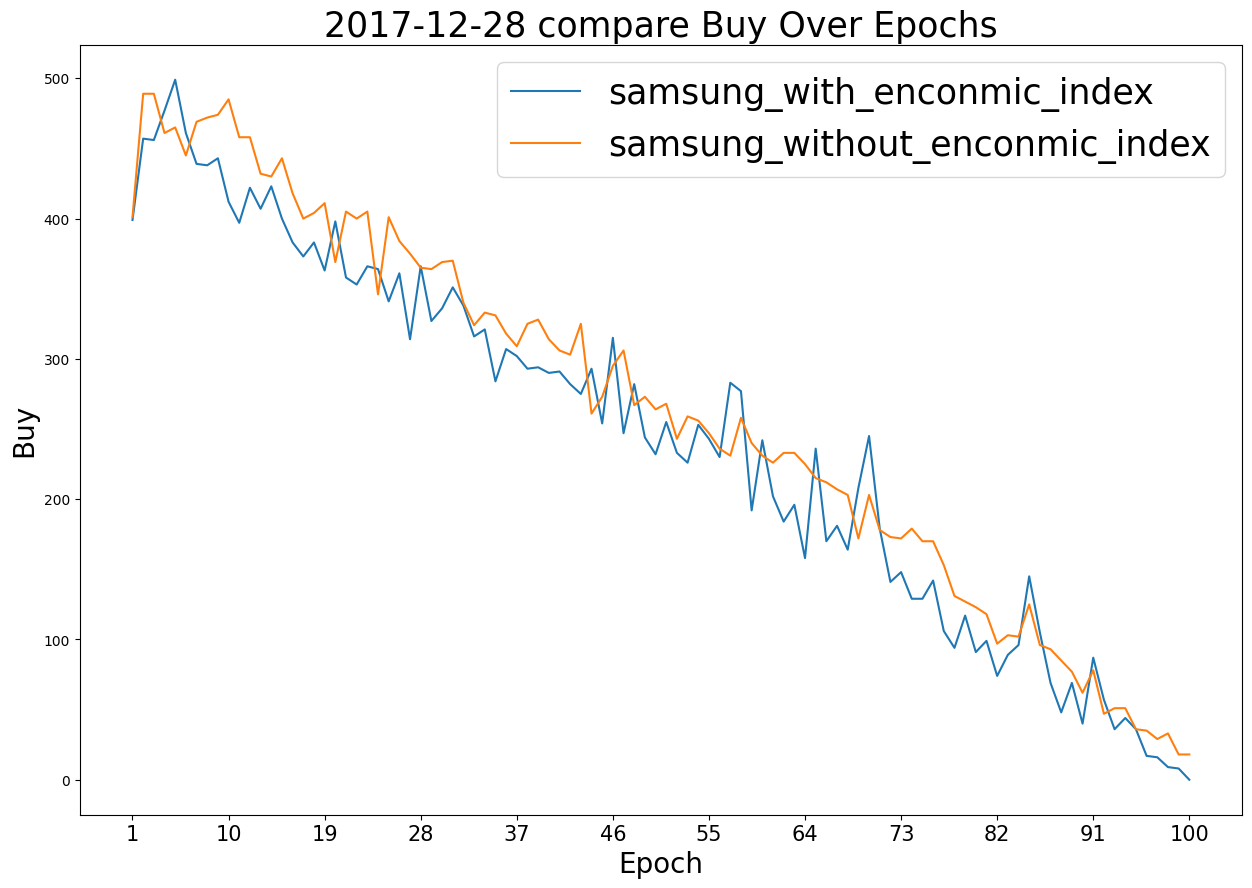

In [29]:
plt.figure(figsize=(15, 10))
plt.plot(samsung['Epoch'], samsung['Buy'], label='samsung_with_enconmic_index')
plt.plot(non_samsung['Epoch'], non_samsung['Buy'], label='samsung_without_enconmic_index')
plt.xticks(np.arange(min(samsung['Epoch']), max(samsung['Epoch'])+1, 9), fontsize=15)
plt.legend(fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Buy', fontsize=20)
plt.title('2017-12-28 compare Buy Over Epochs', fontsize=25)

Text(0.5, 1.0, '2017-12-28 compare Hold Over Epochs')

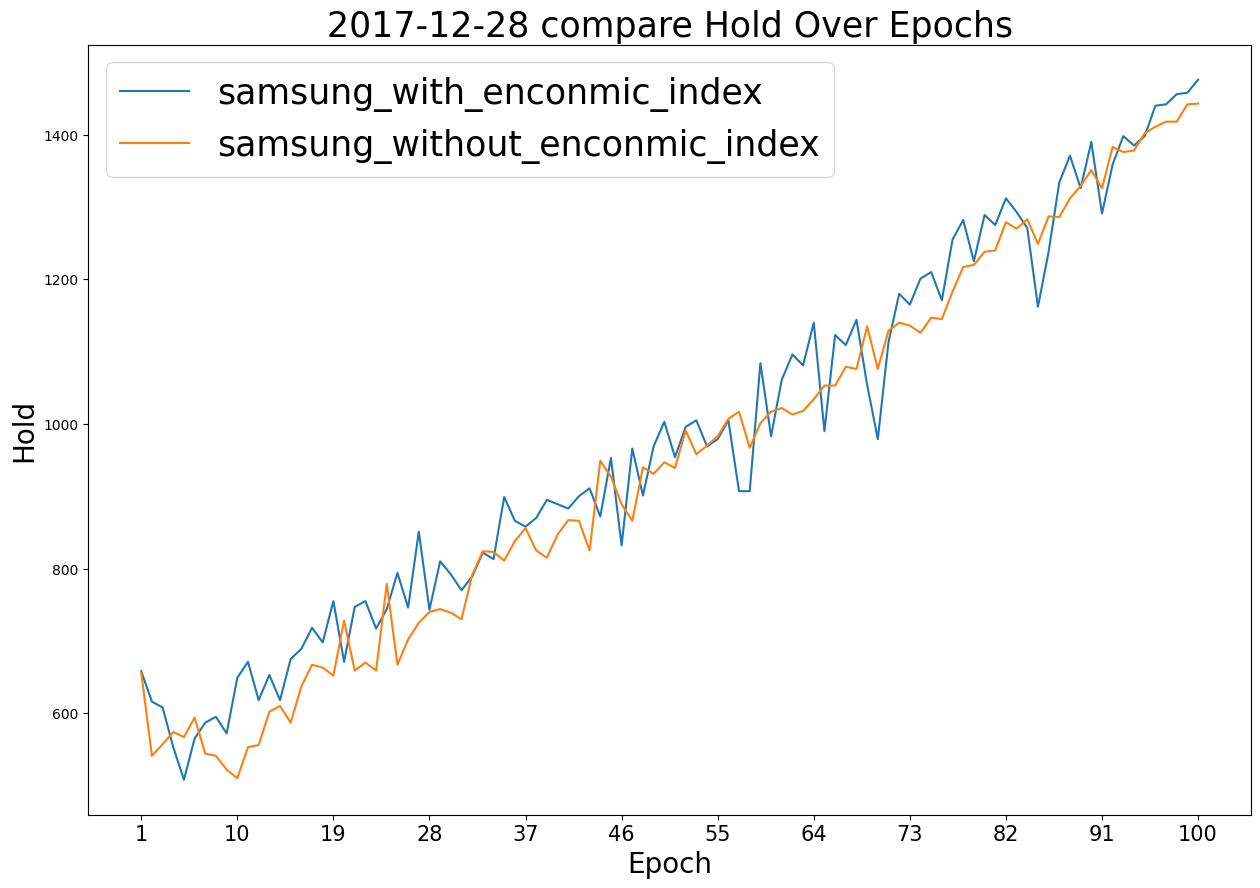

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(samsung['Epoch'], samsung['Hold'], label='samsung_with_enconmic_index')
plt.plot(non_samsung['Epoch'], non_samsung['Hold'], label='samsung_without_enconmic_index')
plt.xticks(np.arange(min(samsung['Epoch']), max(samsung['Epoch'])+1, 9), fontsize=15)
plt.legend(fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Hold', fontsize=20)
plt.title('2017-12-28 compare Hold Over Epochs', fontsize=25)

Text(0.5, 1.0, '2017-12-28 compare Hold Over Epochs')

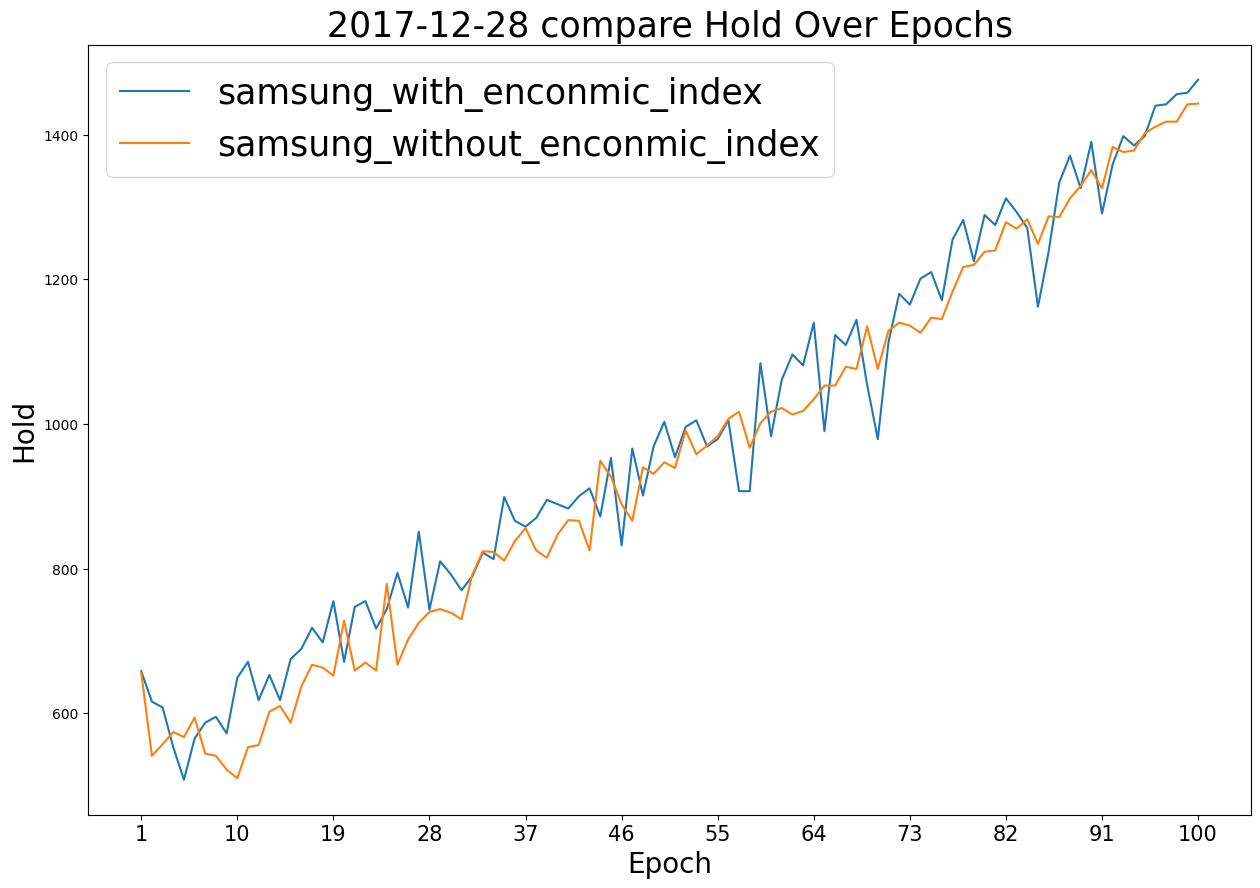

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(samsung['Epoch'], samsung['Hold'], label='samsung_with_enconmic_index')
plt.plot(non_samsung['Epoch'], non_samsung['Hold'], label='samsung_without_enconmic_index')
plt.xticks(np.arange(min(samsung['Epoch']), max(samsung['Epoch'])+1, 9), fontsize=15)
plt.legend(fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Hold', fontsize=20)
plt.title('2017-12-28 compare Hold Over Epochs', fontsize=25)

Text(0.5, 0, 'Epoch')

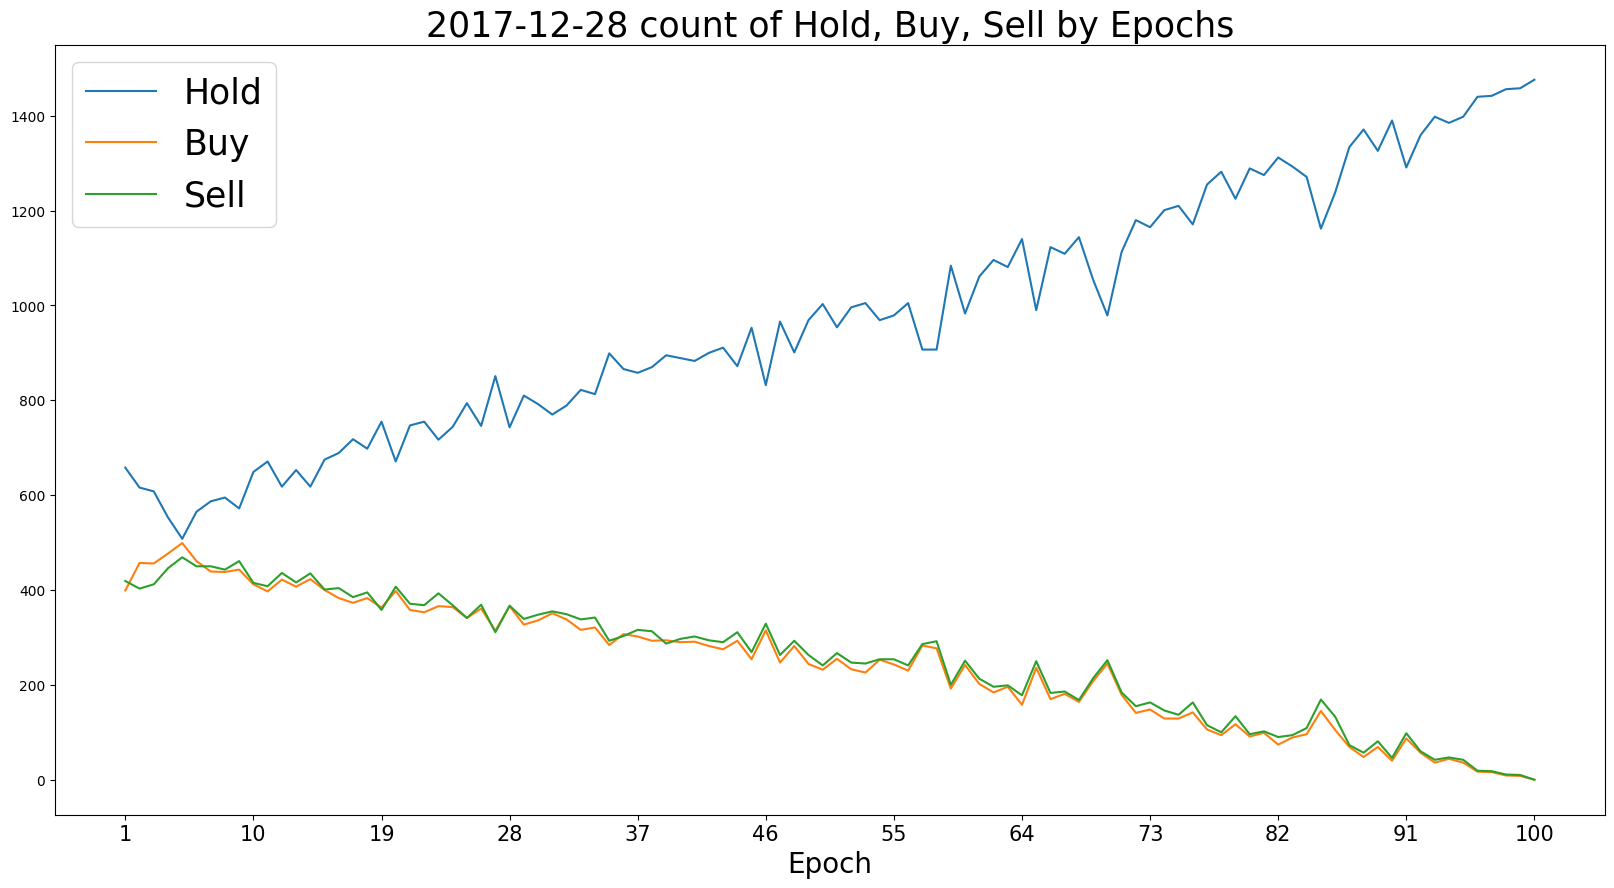

In [32]:
# 그래프 그리기
# epoch에 따른 Hold, Buy, Sell 횟수
plt.figure(figsize=(20, 10))
plt.plot(samsung['Epoch'], samsung['Hold'], label='Hold')
plt.plot(samsung['Epoch'], samsung['Buy'], label='Buy')
plt.plot(samsung['Epoch'], samsung['Sell'], label='Sell')
plt.legend(fontsize=25)
plt.xticks(np.arange(min(samsung['Epoch']), max(samsung['Epoch'])+1, 9), fontsize=15)
# 그래프 제목과 레이블 추가
plt.title('2017-12-28 count of Hold, Buy, Sell by Epochs', fontsize=25)
plt.xlabel('Epoch', fontsize=20)

## 하이닉스 시각화

In [33]:
initial_investment = 50000000
hyninx['Log_Return'] = np.log(hyninx['PV'] / initial_investment)
non_hynix['Log_Return'] = np.log(non_hynix['PV'] / initial_investment)
hinix_train['Log_Return'] = np.log(hinix_train['Close'] / hinix_train['Close'].shift(1))
hinix_train['Cumulative_Log_Return'] = hinix_train['Log_Return'].cumsum()




In [34]:
hyninx['Epoch'] = hyninx['Epoch'].astype(int)

In [35]:
# datetime으로 바꿈
samsung_train['date'] = pd.to_datetime(samsung_train['date'])

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

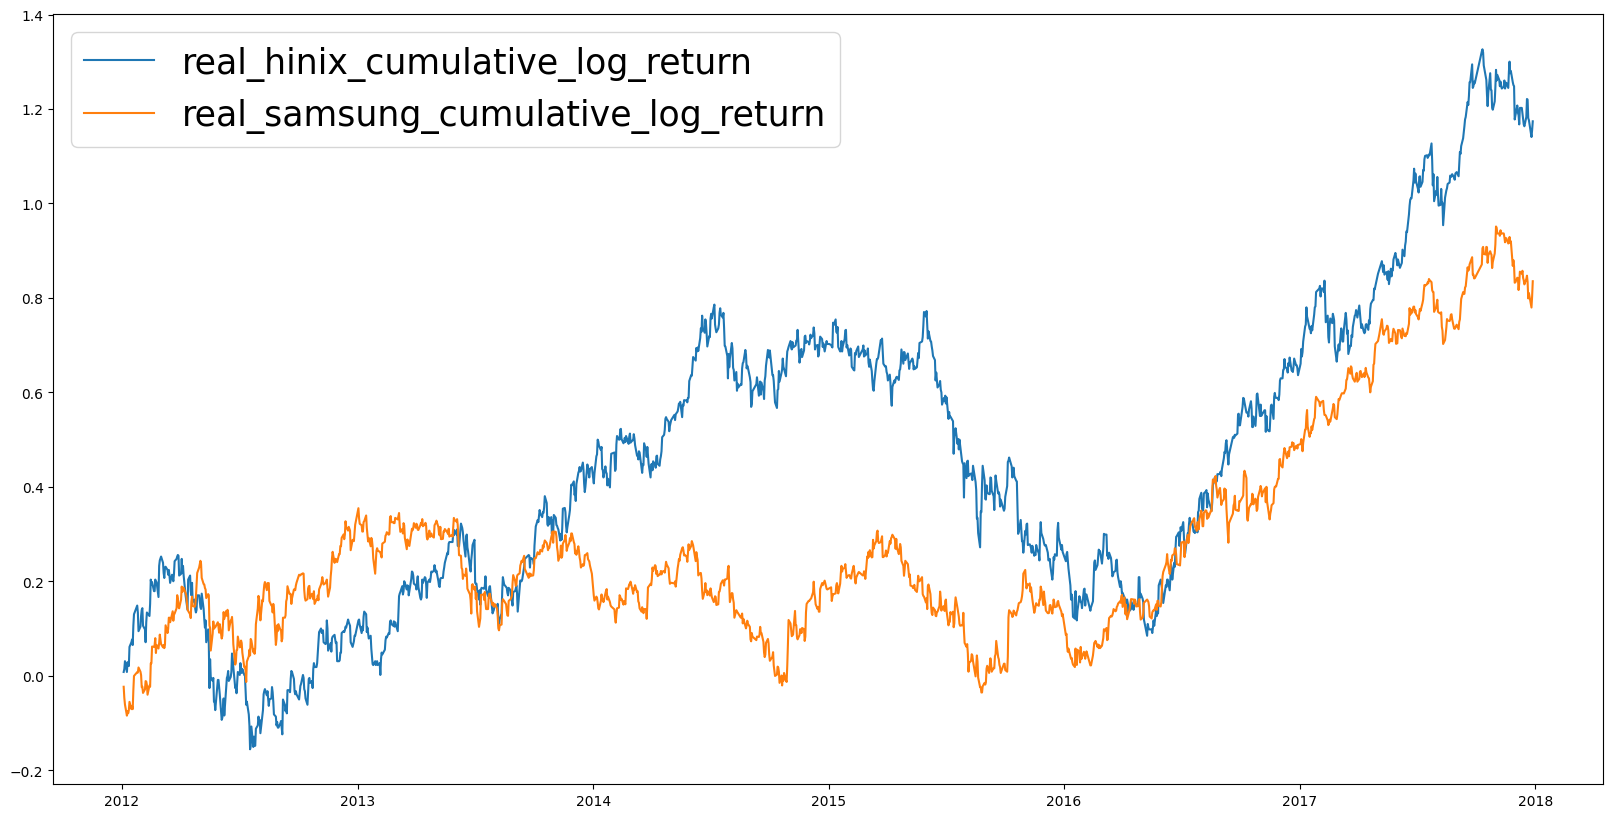

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(hinix_train['date'], hinix_train['Cumulative_Log_Return'], label='real_hinix_cumulative_log_return')
plt.plot(samsung_train['date'], samsung_train['Cumulative_Log_Return'], label='real_samsung_cumulative_log_return')
plt.legend(fontsize=25)
plt.xticks(np.arange(samsung_train['date'], max(samsung_train['date'])+1, 50), fontsize=15)
plt.xlabel('date', fontsize=20)
plt.ylabel('cumulative_log_return', fontsize=20)
plt.title('cumulative_log_return', fontsize=25)

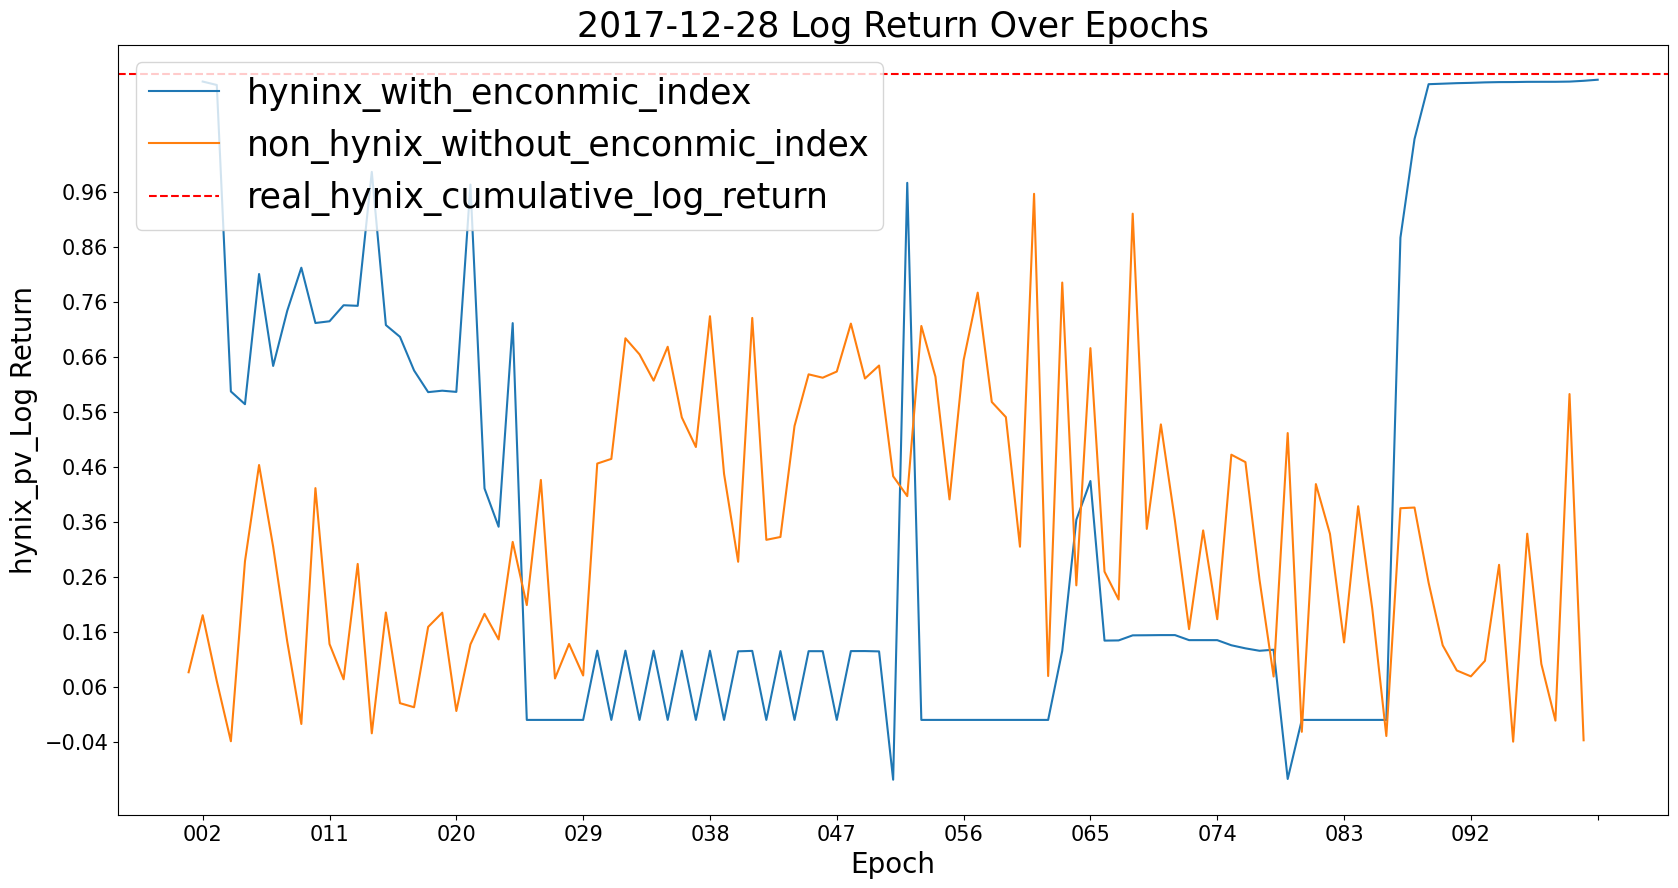

In [37]:
# 그래프 그리기
plt.figure(figsize=(20, 10))
plt.plot(hyninx['Epoch'], hyninx['Log_Return'], label='hyninx_with_enconmic_index')
plt.plot(non_hynix['Epoch'], non_hynix['Log_Return'], label='non_hynix_without_enconmic_index')
plt.axhline(y=hinix_train['Cumulative_Log_Return'].iloc[-1], color='r', linestyle='--', label='real_hynix_cumulative_log_return')

# 그래프 제목과 레이블 추가
plt.title('2017-12-28 Log Return Over Epochs', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('hynix_pv_Log Return', fontsize=20)
plt.legend(fontsize=25)
plt.xticks(np.arange(min(hyninx['Epoch']), max(hyninx['Epoch'])+1, 9), fontsize=15)
plt.yticks(np.arange(min(non_hynix['Log_Return']), max(non_hynix['Log_Return'])+0.1, 0.1), fontsize=15)
# 그래프 표시
plt.show()

In [38]:
non_hynix['Sell'] = non_hynix['Sell'].astype(int)
hyninx['Sell'] = hyninx['Sell'].astype(int)

In [39]:
non_hynix['Buy'] = non_hynix['Buy'].astype(int)
hyninx['Buy'] = hyninx['Buy'].astype(int)

In [40]:
non_hynix['Hold'] = non_hynix['Hold'].astype(int)
hyninx['Hold'] = hyninx['Hold'].astype(int)

Text(0.5, 1.0, '2017-12-28 compare Sell Over Epochs')

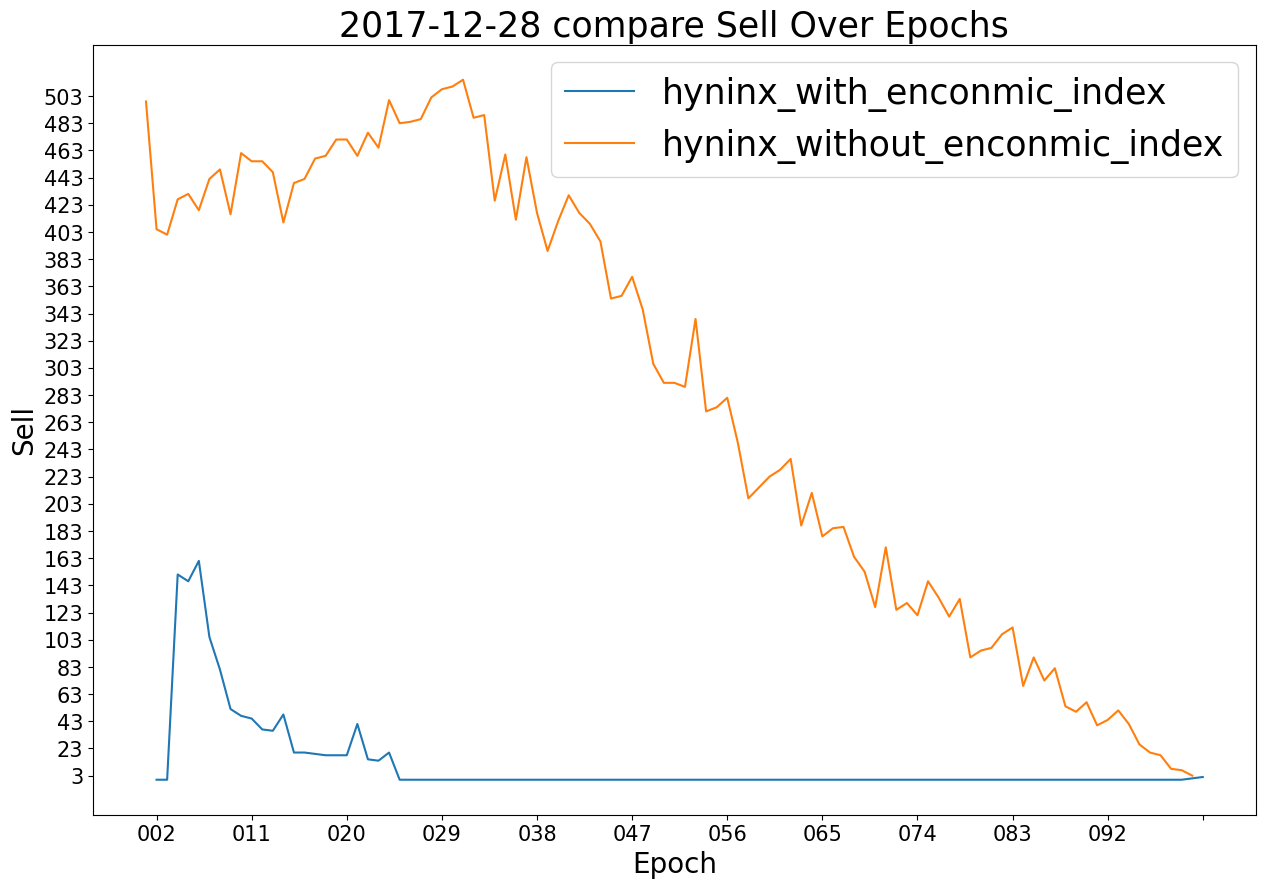

In [41]:
plt.figure(figsize=(15, 10))
plt.plot(hyninx['Epoch'], hyninx['Sell'], label='hyninx_with_enconmic_index')
plt.plot(non_hynix['Epoch'], non_hynix['Sell'], label='hyninx_without_enconmic_index')
plt.xticks(np.arange(min(hyninx['Epoch']), max(hyninx['Epoch'])+1, 9), fontsize=15)
plt.yticks(np.arange(min(non_hynix['Sell']), max(non_hynix['Sell']), 20), fontsize=15)
plt.legend(fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Sell', fontsize=20)
plt.title('2017-12-28 compare Sell Over Epochs', fontsize=25)

Text(0.5, 1.0, '2017-12-28 compare Buy Over Epochs')

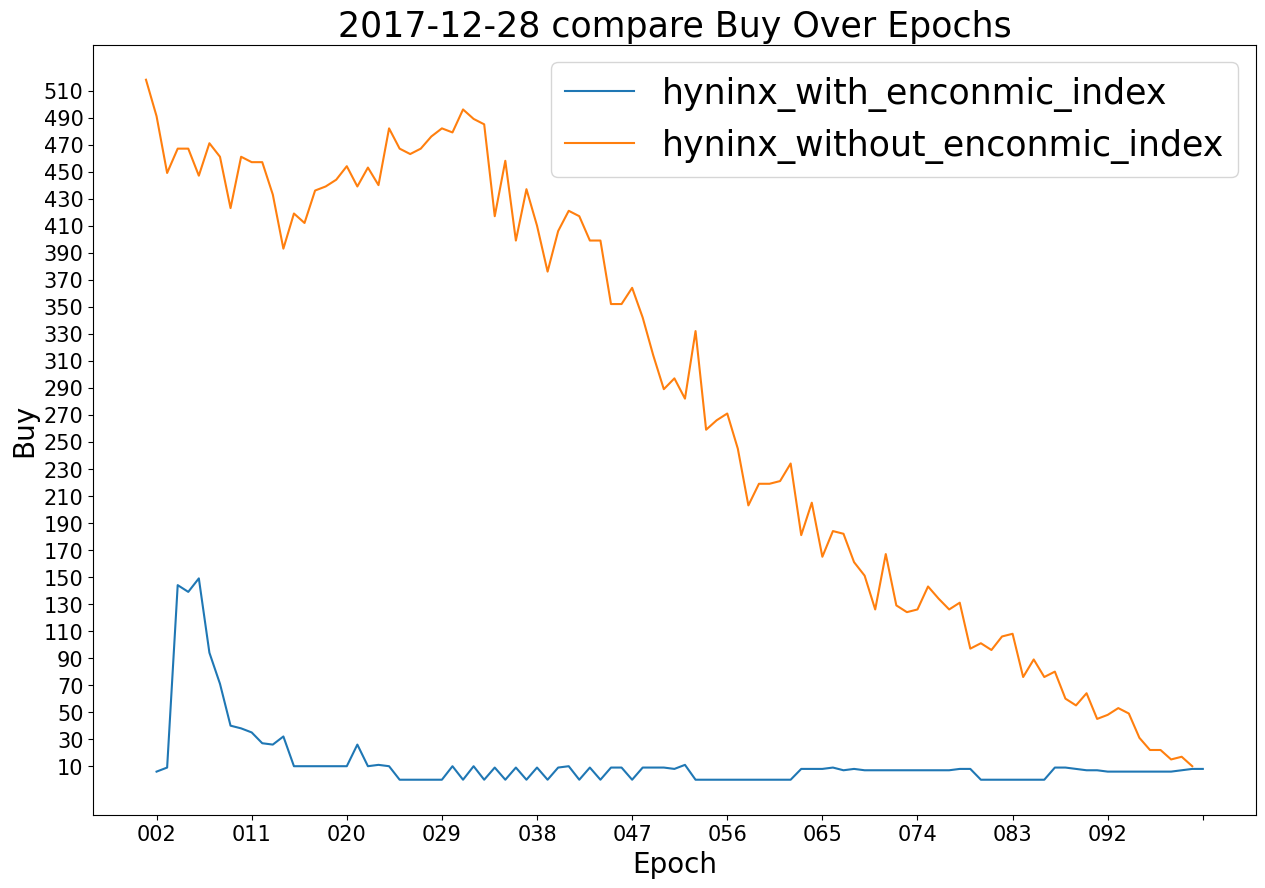

In [42]:
plt.figure(figsize=(15, 10))
plt.plot(hyninx['Epoch'], hyninx['Buy'], label='hyninx_with_enconmic_index')
plt.plot(non_hynix['Epoch'], non_hynix['Buy'], label='hyninx_without_enconmic_index')
plt.xticks(np.arange(min(hyninx['Epoch']), max(hyninx['Epoch'])+1, 9), fontsize=15)
plt.yticks(np.arange(min(non_hynix['Buy']), max(non_hynix['Buy']), 20), fontsize=15)
plt.legend(fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Buy', fontsize=20)
plt.title('2017-12-28 compare Buy Over Epochs', fontsize=25)

Text(0.5, 1.0, '2017-12-28 compare Hold Over Epochs')

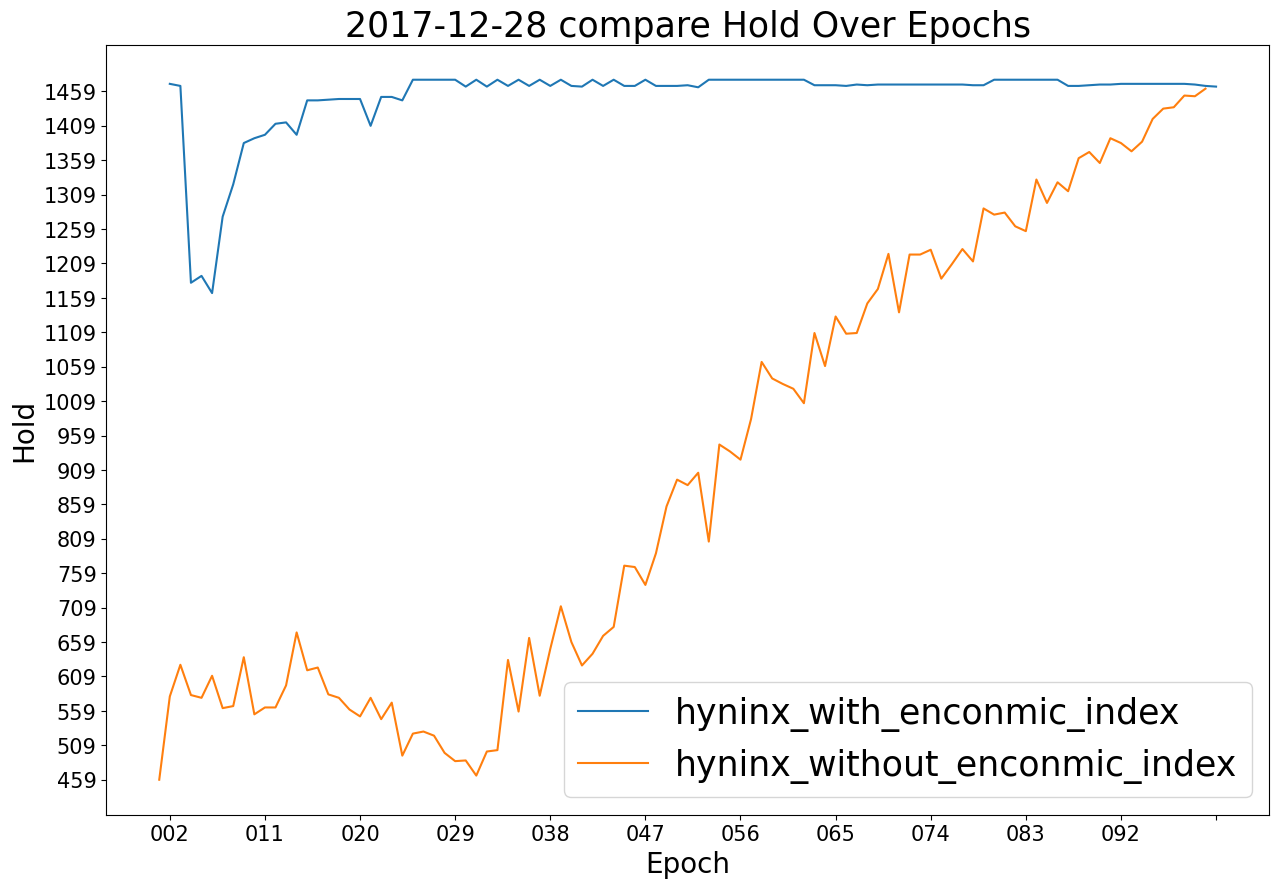

In [43]:
plt.figure(figsize=(15, 10))
plt.plot(hyninx['Epoch'], hyninx['Hold'], label='hyninx_with_enconmic_index')
plt.plot(non_hynix['Epoch'], non_hynix['Hold'], label='hyninx_without_enconmic_index')
plt.xticks(np.arange(min(hyninx['Epoch']), max(hyninx['Epoch'])+1, 9), fontsize=15)
plt.yticks(np.arange(min(non_hynix['Hold']), max(non_hynix['Hold']), 50), fontsize=15)
plt.legend(fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Hold', fontsize=20)
plt.title('2017-12-28 compare Hold Over Epochs', fontsize=25)

# Testset 확인


In [88]:
# JSON 파일 경로
json_file_path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/predict_hinx_model_dqn_dnn/pred_hinx.json'

with open(json_file_path, 'r') as json_file:
    pred_hinx = json.load(json_file)

In [89]:

# JSON 파일 경로
json_file_path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/predict_non_hinix_model_dqn_dnn/pred_non_hinx.json'

with open(json_file_path, 'r') as json_file:
    pred_non_hinx = json.load(json_file)

In [90]:
# JSON 파일 경로
json_file_path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/predict_non_samsung_model_dqn_dnn/pred_non_samsung.json'

with open(json_file_path, 'r') as json_file:
    pred_non_samsung = json.load(json_file)

In [91]:
# JSON 파일 경로
json_file_path = '/Users/pjy97/Desktop/한양대/1-1/강화학습/project/code/models/predict_samsung_model_dqn_dnn/pred_samsung.json'

with open(json_file_path, 'r') as json_file:
    pred_samsung = json.load(json_file)

In [92]:
def return_action(data,li):
    for dt in data:

        max_index = max(enumerate(dt[1]), key=lambda x: x[1])[0]
        li.append(max_index)
    return li

In [93]:
pred_hinx = return_action(pred_hinx,[])
pred_non_hinx = return_action(pred_non_hinx,[])
pred_non_samsung = return_action(pred_non_samsung,[])
pred_samsung = return_action(pred_samsung,[])

In [96]:
hyninx['Stocks'] = hyninx['Stocks'].astype(int)

In [97]:
pred_hinx_tot = pd.DataFrame([pred_hinx, pred_non_hinx], index=['pred_hinx', 'pred_non_hinx']).T

In [100]:
pred_hinx_tot = pd.DataFrame([pred_samsung, pred_non_samsung], index=['pred_hinx', 'pred_non_hinx']).T

In [103]:
pred_hinx_tot.value_counts()

pred_hinx  pred_non_hinx
2          2                1223
Name: count, dtype: int64

In [104]:
def return_action(data, pred_data):
    save_stock_nums = []
    remain_moneys = []
    total_returns = []
    invest_money = 50000000
    start_stock = int(50000000 / data['Close'][0])
    remain_money = invest_money - (start_stock * data['Close'][0])
    remain_moneys.append(remain_money)
    total_returns.append(start_stock * data['Close'][0]+remain_money)
    save_stock_nums.append(start_stock)
    for i in zip(pred_data, data['Close']):
        # 매수 시그널
        if i[0] == 0:
            stcok_num = int(remain_money / i[1])
            if stcok_num > 0:
                remain_money = remain_money - (stcok_num * i[1])
                save_stock_nums.append(save_stock_nums[-1] + stcok_num)
                remain_moneys.append(remain_money)
                total_returns.append((save_stock_nums[-1] * i[1]) + remain_money)
            else:
                remain_moneys.append(remain_money)
                save_stock_nums.append(save_stock_nums[-1])
                total_returns.append((save_stock_nums[-1] * i[1]) + remain_moneys[-1])
        # 매도 시그널
        elif i[0] == 1:
            stock_num = save_stock_nums[-1]
            if stock_num > 0:
                remain_money = remain_money + (stock_num * i[1])
                save_stock_nums.append(0)
                remain_moneys.append(remain_money)
                total_returns.append((save_stock_nums[-1] * i[1]) + remain_moneys[-1])
            else:
                remain_moneys.append(remain_money)
                save_stock_nums.append(save_stock_nums[-1])
                total_returns.append((save_stock_nums[-1] * i[1]) + remain_moneys[-1])
        else:
            save_stock_nums.append(save_stock_nums[-1])
            remain_moneys.append(remain_money)
            total_returns.append((save_stock_nums[-1] * i[1]) + remain_moneys[-1])
    
    return save_stock_nums, remain_moneys, total_returns



In [105]:
save_non_hinx_stock_nums, remain_non_hinx_moneys, total_non_hinx_returns = return_action(hinix_test, pred_non_hinx)
save_hinx_stock_nums, remain_hinx_moneys, total_hinx_returns = return_action(hinix_test, pred_hinx)
save_non_samsung_stock_nums, remain_non_samsung_moneys, total_non_samsung_returns = return_action(samsung_test, pred_non_samsung)
save_samsung_stock_nums, remain_samsung_moneys, total_samsung_returns = return_action(samsung_test, pred_samsung)

/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_60858/1714504084.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start_stock = int(50000000 / data['Close'][0])
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_60858/1714504084.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  remain_money = invest_money - (start_stock * data['Close'][0])
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_60858/1714504084.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

In [106]:
pred_hinx_data = pd.DataFrame([total_non_hinx_returns, total_hinx_returns], index=['total_non_hinx_returns', 'total_hinx_returns']).T
pred_samsung_data = pd.DataFrame([total_non_samsung_returns, total_samsung_returns], index=['total_non_samsung_returns', 'total_samsung_returns']).T

In [107]:
pred_samsung_data

,total_non_samsung_returns,total_samsung_returns
0,50000000.0,50000000.0
1,50000000.0,50000000.0
2,50588000.0,50588000.0
3,50058800.0,50058800.0
4,51078000.0,51078000.0
...,...,...
1219,58310400.0,58310400.0
1220,58506400.0,58506400.0
1221,59290400.0,59290400.0
1222,58114400.0,58114400.0


In [108]:
pred_hinx_data

,total_non_hinx_returns,total_hinx_returns
0,50000000.0,50000000.0
1,50000000.0,50000000.0
2,50000000.0,50717200.0
3,50000000.0,50326000.0
4,50000000.0,51760400.0
...,...,...
1219,38337800.0,48761200.0
1220,38337800.0,48761200.0
1221,38337800.0,48761200.0
1222,38337800.0,48761200.0


In [109]:
#전일 대비 로그리턴 수익률
pred_hinx_data['hinx_Log_Return'] = np.log(pred_hinx_data['total_hinx_returns'] / pred_hinx_data['total_hinx_returns'].shift(1))
pred_hinx_data['non_hinx_Log_Return'] = np.log(pred_hinx_data['total_non_hinx_returns'] / pred_hinx_data['total_non_hinx_returns'].shift(1))
pred_samsung_data['samsung_Log_Return'] = np.log(pred_samsung_data['total_samsung_returns'] / pred_samsung_data['total_samsung_returns'].shift(1))
pred_samsung_data['non_samsung_Log_Return'] = np.log(pred_samsung_data['total_non_samsung_returns'] / pred_samsung_data['total_non_samsung_returns'].shift(1))


In [110]:
#누적 로그 수익률
pred_hinx_data['non_hinx_Cumulative_Log_Return'] = pred_hinx_data['non_hinx_Log_Return'].cumsum()
pred_hinx_data['hinx_Cumulative_Log_Return'] = pred_hinx_data['hinx_Log_Return'].cumsum()
pred_samsung_data['non_samsung_Cumulative_Log_Return'] = pred_samsung_data['non_samsung_Log_Return'].cumsum()
pred_samsung_data['samsung_Cumulative_Log_Return'] = pred_samsung_data['samsung_Log_Return'].cumsum()

In [111]:
hinix_test['cumulative_log_return'] = hinix_test['Log_Return'].cumsum()
samsung_test['cumulative_log_return'] = samsung_test['Log_Return'].cumsum()

In [112]:
samsung_test

,Close,econmic_index,EMA_5,EMA_20,MACD,Log_Return,date,cumulative_log_return
date,,,,,,,,
2018-01-02,51020.0,0,50324.583221,51021.533838,-696.950617,0.001177,2018-01-02,0.001177
2018-01-03,51620.0,0,50756.388814,51078.530615,-322.141801,0.011691,2018-01-03,0.012868
2018-01-04,51080.0,0,50864.259209,51078.670556,-214.411347,-0.010516,2018-01-04,0.002352
2018-01-05,52120.0,0,51282.839473,51177.844789,104.994684,0.020156,2018-01-05,0.022508
2018-01-08,52020.0,0,51528.559649,51258.050047,270.509601,-0.001920,2018-01-08,0.020587
...,...,...,...,...,...,...,...,...
2022-12-12,59500.0,-1,59766.130159,60293.986828,-527.856669,-0.015013,2022-12-12,0.154935
2022-12-13,59700.0,-1,59744.086772,60237.416654,-493.329881,0.003356,2022-12-13,0.158291
2022-12-14,60500.0,-1,59996.057848,60262.424592,-266.366743,0.013311,2022-12-14,0.171602


In [114]:
pred_hinx_data.dropna(inplace=True)

In [115]:
pred_samsung_data.dropna(inplace=True)

In [116]:
# 인덱스 저장
samsung_test.index = samsung_test['date']
hinix_test.index = hinix_test['date']
pred_hinx_data.index = hinix_test.index
pred_samsung_data.index = samsung_test.index

Text(0.5, 1.0, 'cumulative_log_return')

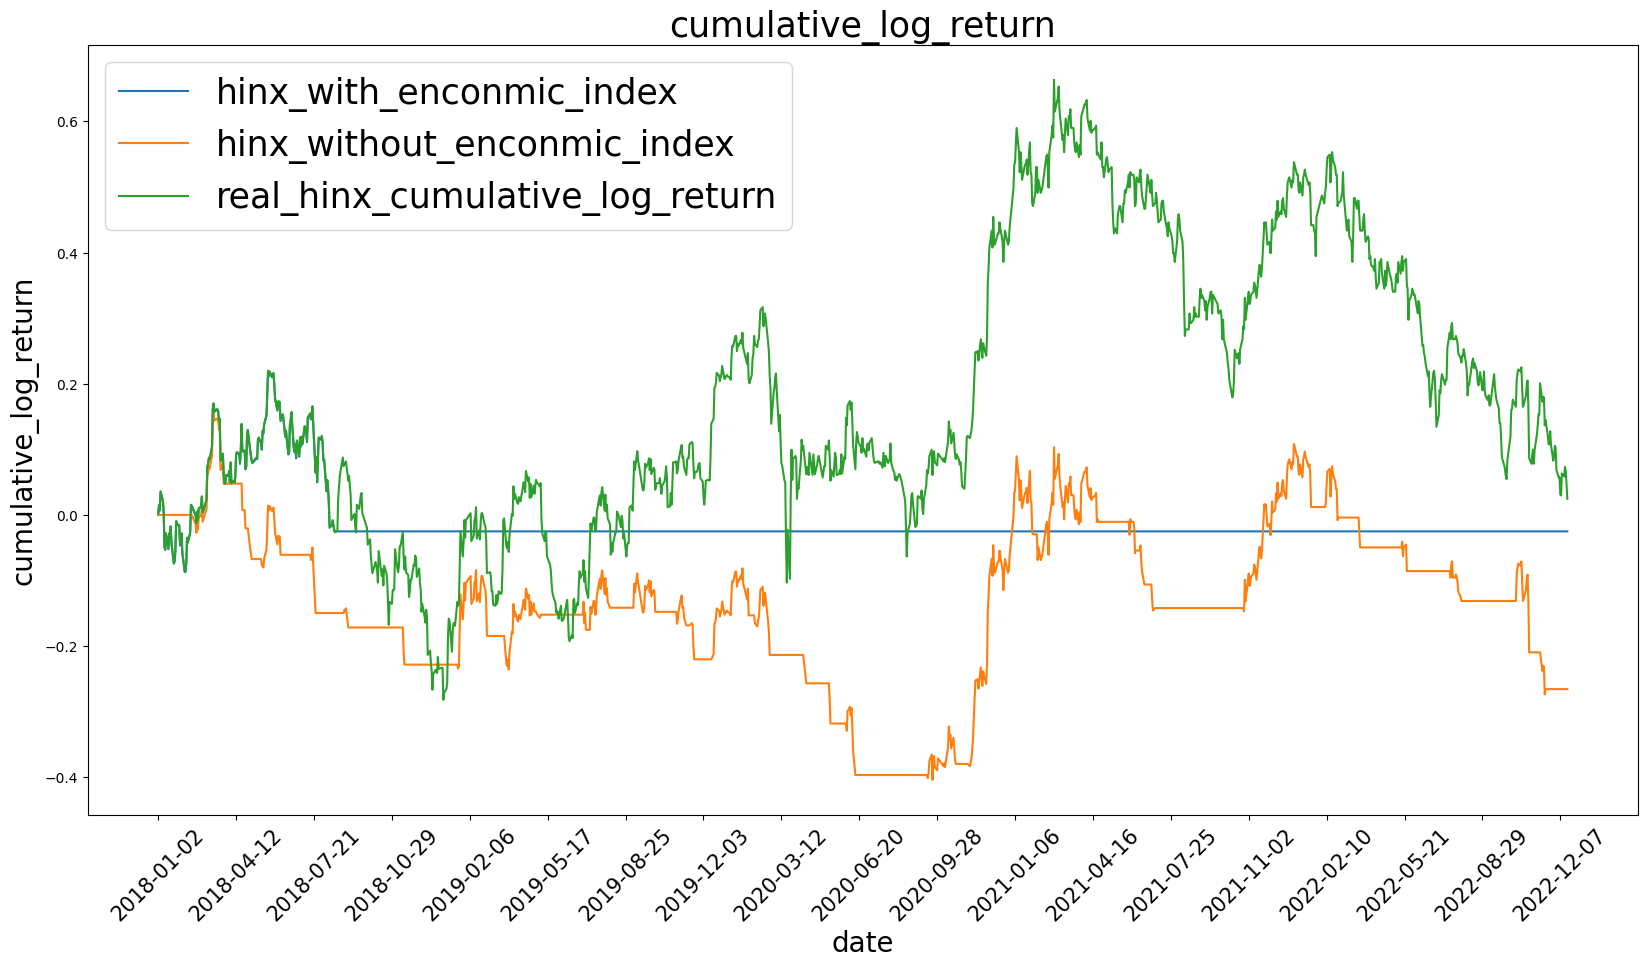

In [117]:
# 로그 누적 수익률을 보이기

plt.figure(figsize=(20, 10))
plt.plot(pred_hinx_data['hinx_Cumulative_Log_Return'], label='hinx_with_enconmic_index')
plt.plot(pred_hinx_data['non_hinx_Cumulative_Log_Return'], label='hinx_without_enconmic_index')
plt.plot(hinix_test['cumulative_log_return'], label='real_hinx_cumulative_log_return')
plt.legend(fontsize=25)
date_range = pd.date_range(start=hinix_test.index.min(), end=hinix_test.index.max(), freq='100D')  # 날짜 간격을 'D'로 설정
plt.xticks(date_range, fontsize=15, rotation=45)  # rotation 파라미터를 사용하여 텍스트 회전 설정
plt.xlabel('date', fontsize=20)
plt.ylabel('cumulative_log_return', fontsize=20)
plt.title('cumulative_log_return', fontsize=25)


In [118]:
pred_samsung_data

,total_non_samsung_returns,total_samsung_returns,samsung_Log_Return,non_samsung_Log_Return,non_samsung_Cumulative_Log_Return,samsung_Cumulative_Log_Return
date,,,,,,
2018-01-02,50000000.0,50000000.0,0.000000,0.000000,0.000000,0.000000
2018-01-03,50588000.0,50588000.0,0.011691,0.011691,0.011691,0.011691
2018-01-04,50058800.0,50058800.0,-0.010516,-0.010516,0.001175,0.001175
2018-01-05,51078000.0,51078000.0,0.020156,0.020156,0.021331,0.021331
2018-01-08,50980000.0,50980000.0,-0.001920,-0.001920,0.019410,0.019410
...,...,...,...,...,...,...
2022-12-12,58310400.0,58310400.0,-0.015013,-0.015013,0.153757,0.153757
2022-12-13,58506400.0,58506400.0,0.003356,0.003356,0.157113,0.157113
2022-12-14,59290400.0,59290400.0,0.013311,0.013311,0.170424,0.170424


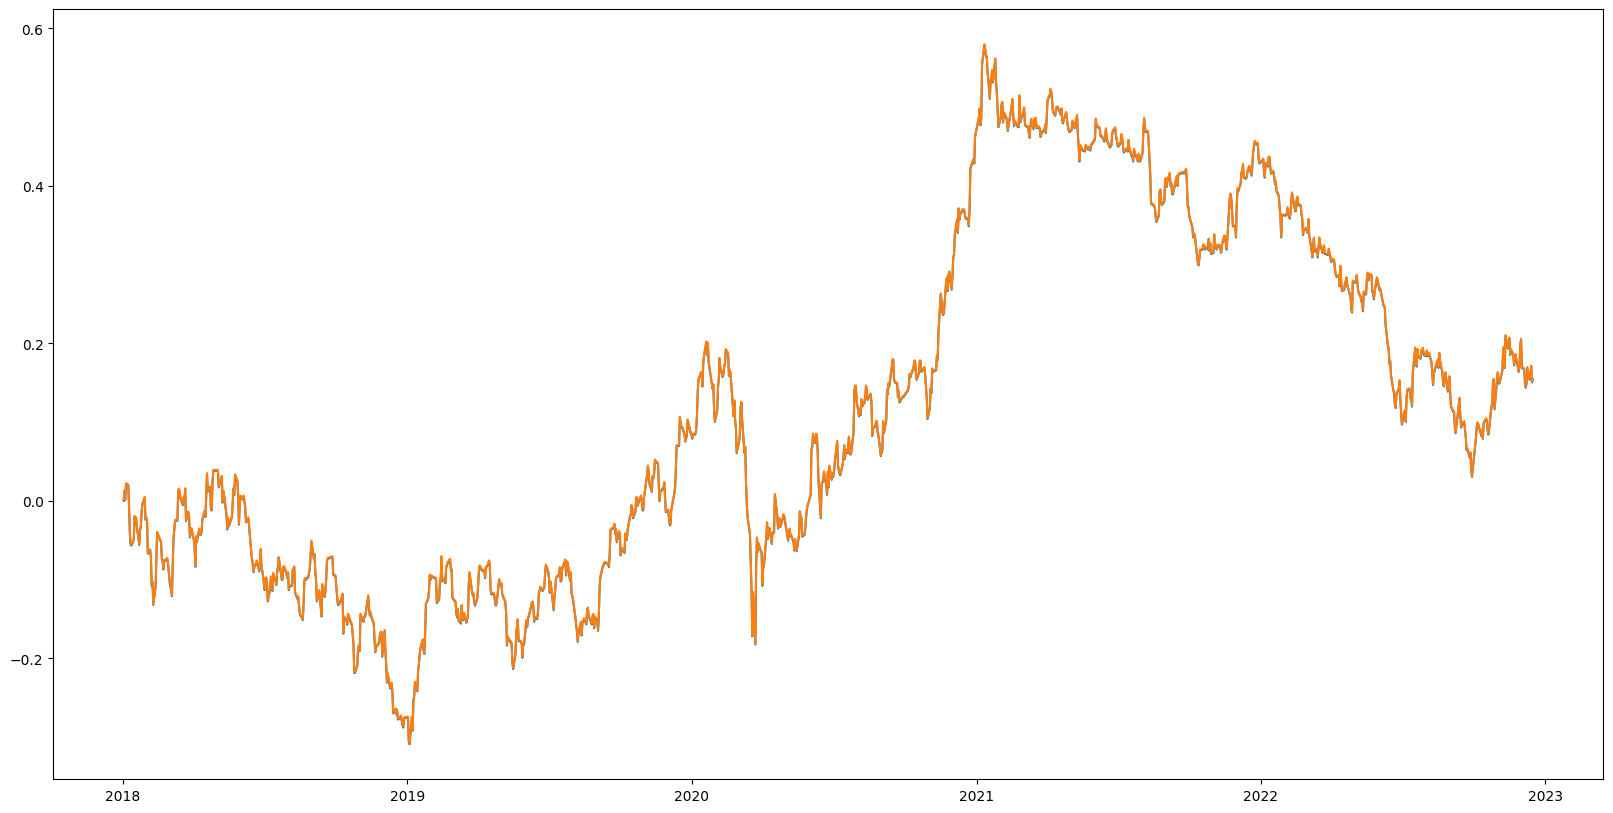

In [123]:
# 로그 누적 수익률을 보이기

plt.figure(figsize=(20, 10))
plt.plot(pred_samsung_data['samsung_Cumulative_Log_Return'], label='samsung_with_enconmic_index')
# plt.plot(pred_samsung_data['non_samsung_Cumulative_Log_Return'], label='samsung_without_enconmic_index')
plt.plot(samsung_test['cumulative_log_return'], label='real_samsung_cumulative_log_return')


Text(0.5, 1.0, 'cumulative_log_return')

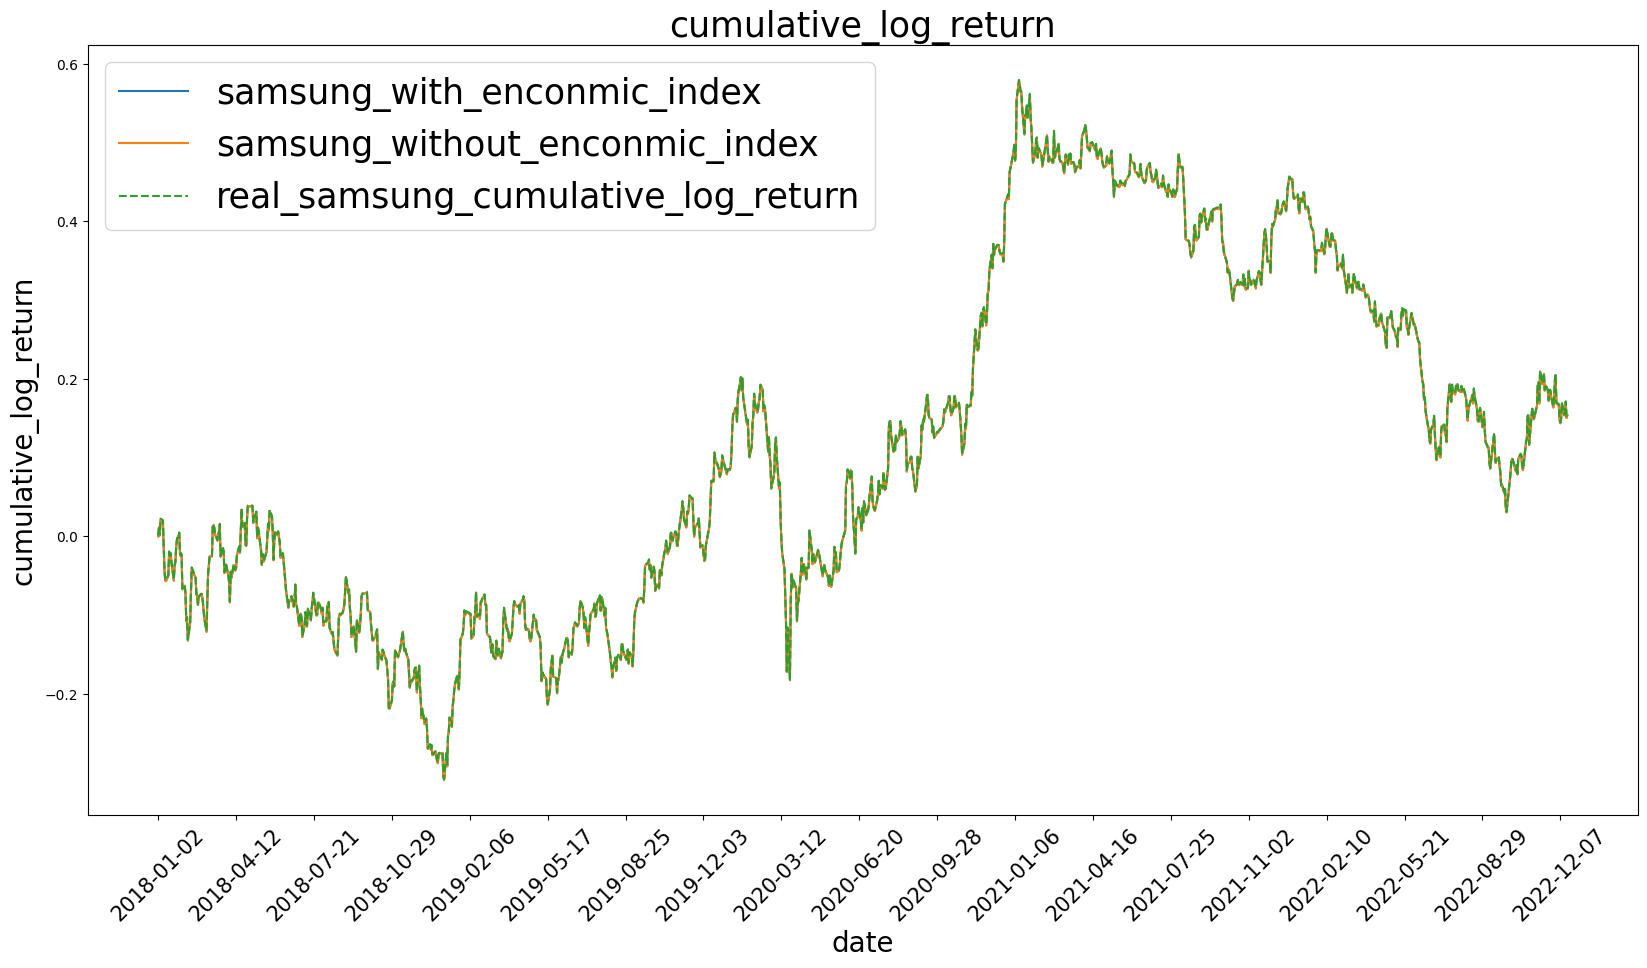

In [124]:
# 로그 누적 수익률을 보이기

plt.figure(figsize=(20, 10))
plt.plot(pred_samsung_data['samsung_Cumulative_Log_Return'], label='samsung_with_enconmic_index')
plt.plot(pred_samsung_data['non_samsung_Cumulative_Log_Return'], label='samsung_without_enconmic_index')
plt.plot(samsung_test['cumulative_log_return'], label='real_samsung_cumulative_log_return', linestyle='--')
plt.legend(fontsize=25)
date_range = pd.date_range(start=hinix_test.index.min(), end=hinix_test.index.max(), freq='100D')  # 날짜 간격을 'D'로 설정
plt.xticks(date_range, fontsize=15, rotation=45)  # rotation 파라미터를 사용하여 텍스트 회전 설정
plt.xlabel('date', fontsize=20)
plt.ylabel('cumulative_log_return', fontsize=20)
plt.title('cumulative_log_return', fontsize=25)
